In [116]:
import pandas as pd
import re

# Preprocessing current data for prediction

In [117]:
df = pd.read_csv('../data/raw/location_rent_with_coordinates.csv')

In [118]:
# Create a condition to check if the name has a flat number (pattern "number/")

df['Apartment'] = df['name'].apply(lambda x: 1 if '/' in x else 0)
df.head(5)

,name,Bed,weekly_rent,latitude,longitude,Apartment
0,"1208/50 Albert Street, South Melbourne VIC 3205",1,520.0,-37.834344,144.955904,1
1,"64 Mills Street, Albert Park VIC 3206",3,1495.0,-37.846426,144.958009,0
2,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,0
3,"1104/70 Southbank Boulevard, Southbank VIC 3006",1,420.0,-37.823158,144.963953,1
4,"167 Charman Road, Beaumaris VIC 3193",4,950.0,-37.974606,145.053631,0


In [119]:
# Function to extract the suburb and postcode from the 'name' column
def extract_location_postcode(address):
    # Regex pattern to capture the suburb name and postcode (VIC followed by 4 digits)
    pattern = r'(?P<suburb>[A-Za-z\s]+) VIC (?P<postcode>\d{4})'
    match = re.search(pattern, address)
    if match:
        return match.group('suburb').strip(), match.group('postcode')
    return None, None

# Apply the function to each row in the 'name' column
df['Location'], df['Postcode'] = zip(*df['name'].apply(extract_location_postcode))

# delete name column
df = df.drop(columns=['name'])

# Display the modified dataframe
df.head()


,Bed,weekly_rent,latitude,longitude,Apartment,Location,Postcode
0,1,520.0,-37.834344,144.955904,1,South Melbourne,3205
1,3,1495.0,-37.846426,144.958009,0,Albert Park,3206
2,4,460.0,-37.718775,144.554187,0,Weir Views,3338
3,1,420.0,-37.823158,144.963953,1,Southbank,3006
4,4,950.0,-37.974606,145.053631,0,Beaumaris,3193


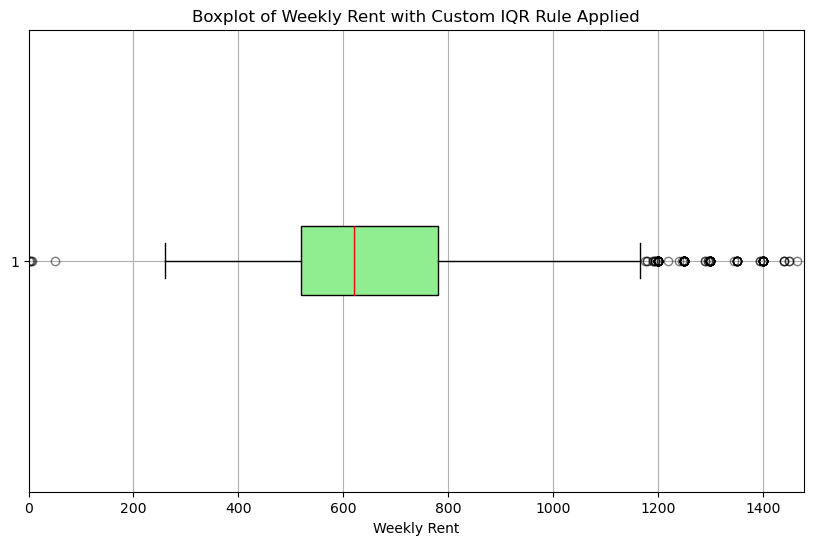

,Bed,weekly_rent,latitude,longitude,Apartment,Location,Postcode
0,1,520.0,-37.834344,144.955904,1,South Melbourne,3205
2,4,460.0,-37.718775,144.554187,0,Weir Views,3338
3,1,420.0,-37.823158,144.963953,1,Southbank,3006
4,4,950.0,-37.974606,145.053631,0,Beaumaris,3193
5,3,1200.0,-37.890515,144.989992,1,Elwood,3184


In [120]:
# Outliers detecting and cleaning

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Filter based on your conditions:
# Apartments (Type 1) with Bed <= 3
# Houses (Type 0) with 2 <= Bed <= 4
df_filtered = df[((df['Apartment'] == 1) & (df['Bed'] <= 3)) | 
                 ((df['Apartment'] == 0) & (df['Bed'].between(2, 4)))]

# Calculate the data volume
N = len(df_filtered['weekly_rent'].dropna())

# Calculate the quartiles and IQR
Q1 = np.percentile(df_filtered['weekly_rent'].dropna(), 25)
Q3 = np.percentile(df_filtered['weekly_rent'].dropna(), 75)
IQR = Q3 - Q1

# Apply the corresponding outlier determination rule based on the number of records N
if N <= 100:
    factor = 1.5
else:
    factor = np.sqrt(np.log(N) - 0.5)

# Calculate the upper and lower bounds for outliers
lower_bound = Q1 - factor * IQR
upper_bound = Q3 + factor * IQR

# Plot a boxplot of the 'weekly_rent' column with outlier bounds
plt.figure(figsize=(10, 6))
plt.boxplot(df_filtered['weekly_rent'].dropna(), vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', color='red', alpha=0.5))

# Set the x-axis limit to the calculated upper bound based on the new IQR rule
plt.xlim(0, upper_bound)
plt.title('Boxplot of Weekly Rent with Custom IQR Rule Applied')
plt.xlabel('Weekly Rent')
plt.grid(True)
plt.show()

# Remove outliers based on the calculated bounds
df_cleaned = df_filtered[(df_filtered['weekly_rent'] >= lower_bound) & 
                         (df_filtered['weekly_rent'] <= upper_bound)]


df_cleaned.head()


In [121]:
df = df_cleaned.groupby(['Location', 'Bed', 'Apartment']).agg(
    Count=('weekly_rent', 'size'),    # Count number of rows
    Median=('weekly_rent', 'median')  # Median of weekly_rent
).reset_index()


In [122]:
# Manually add 'Year' and 'Month' columns with a fixed value (2023 and August)

df['Year'] = 2024
df['Month'] = 'Aug'

In [123]:
df.head()

,Location,Bed,Apartment,Count,Median,Year,Month
0,Abbotsford,1,1,2,587.5,2024,Aug
1,Abbotsford,2,0,2,752.5,2024,Aug
2,Abbotsford,2,1,12,707.5,2024,Aug
3,Abbotsford,3,0,1,900.0,2024,Aug
4,Abbotsford,3,1,3,900.0,2024,Aug


In [124]:
# Define the path for the "curated data" folder
file_path = '../data/landing/2024_rent.csv'

# Save the DataFrame to the specified path in CSV format
df.to_csv(file_path, index=False)

# Preprocessing current data for visualization

In [125]:
current = pd.read_csv('../data/landing/property_with_nearest_distance.csv')

In [126]:
# Create a condition to check if the name has a flat number (pattern "number/")

current['Apartment'] = current['name'].apply(lambda x: 1 if '/' in x else 0)
current.head(3)

,name,Bed,weekly_rent,latitude,longitude,geometry,nearest_tram_stop,nearest_tram_stop_distance_km,nearest_train_stop,nearest_train_stop_distance_km,nearest_bus_stop,nearest_bus_stop_distance_km,nearest_school,nearest_school_distance_km,Apartment
0,"1208/50 Albert Street, South Melbourne VIC 3205",1,520.0,-37.834344,144.955904,POINT (2496118.3794249045 2407409.7981049973),127-South Melbourne Station/Light Rail (South ...,0.136816,67-Camberwell Girls Grammar/Burke Rd (Hawthorn...,1.863573,Ferrars St/Dorcas St (South Melbourne),0.034790,Galilee Regional Catholic Primary School,0.223329,1
1,"64 Mills Street, Albert Park VIC 3206",3,1495.0,-37.846426,144.958009,POINT (2496304.26476775 2406068.9190204293),135-Richardson St/Mills St (Middle Park),0.090635,49-Buchanan Ave/Doncaster Rd (Balwyn North),2.824165,Middle Park PS/Richardson St (Middle Park),0.095911,Middle Park Primary School,0.158652,0
2,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,Hume Ave/Rees Rd (Melton South),1.047037,Al Iman College,1.632357,0


2207


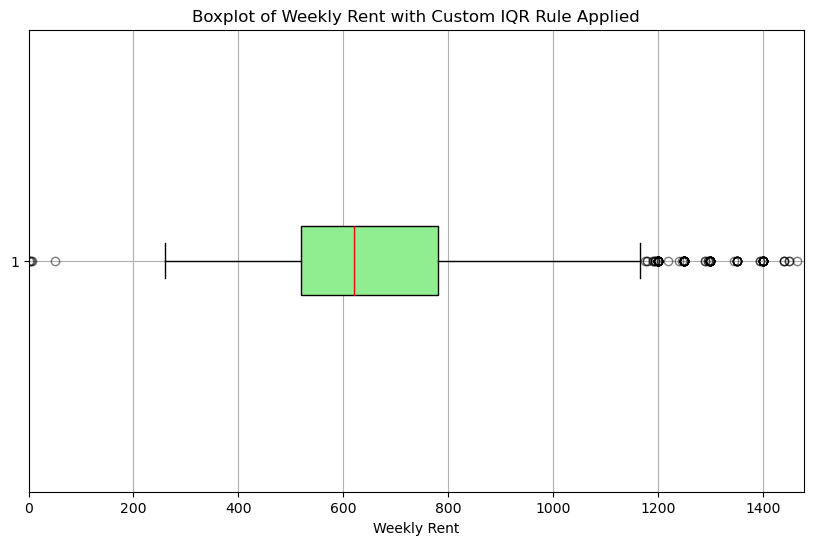

,name,Bed,weekly_rent,latitude,longitude,geometry,nearest_tram_stop,nearest_tram_stop_distance_km,nearest_train_stop,nearest_train_stop_distance_km,nearest_bus_stop,nearest_bus_stop_distance_km,nearest_school,nearest_school_distance_km,Apartment
0,"1208/50 Albert Street, South Melbourne VIC 3205",1,520.0,-37.834344,144.955904,POINT (2496118.3794249045 2407409.7981049973),127-South Melbourne Station/Light Rail (South ...,0.136816,67-Camberwell Girls Grammar/Burke Rd (Hawthorn...,1.863573,Ferrars St/Dorcas St (South Melbourne),0.034790,Galilee Regional Catholic Primary School,0.223329,1
2,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,Hume Ave/Rees Rd (Melton South),1.047037,Al Iman College,1.632357,0
3,"1104/70 Southbank Boulevard, Southbank VIC 3006",1,420.0,-37.823158,144.963953,POINT (2496826.48889558 2408651.6629420286),115-Casino/Southbank/Queens Bridge St (Southbank),0.266535,41-Cantala Ave/Dandenong Rd (Armadale),0.600295,City Rd/Southbank Bvd (Southbank),0.061561,Victorian College Of The Arts Secondary School,0.567526,1
4,"167 Charman Road, Beaumaris VIC 3193",4,950.0,-37.974606,145.053631,POINT (2504712.147891326 2391841.451691285),68-East Brighton/Hawthorn Rd (Brighton East),7.439762,68-Mont Albert Rd/Burke Rd (Camberwell),0.886863,Keith St/Charman Rd (Beaumaris),0.089153,Mentone Girls Secondary College,0.618751,0
5,"10/135 Ormond Esplanade, Elwood VIC 3184",3,1200.0,-37.890515,144.989992,POINT (2499119.7040275545 2401176.234629457),43-Brighton Rd/Glenhuntly Rd (Elsternwick),0.991842,43-Princes Tce/Melville Rd (Pascoe Vale South),1.152975,Ormond Esp/St Kilda St (Elwood),0.076032,Elsternwick Primary School,0.649723,1


In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Apartments (Apartment=1) with Bed <= 3
# Houses (Apartment=0) with 2 <= Bed <= 4
current_filtered = current[((current['Apartment'] == 1) & (current['Bed'] <= 3)) | 
                           ((current['Apartment'] == 0) & (current['Bed'].between(2, 4)))]

# Calculate the data volume
N = len(current_filtered['weekly_rent'].dropna())
print(N)

# Calculate the quartiles and IQR
Q1 = np.percentile(current_filtered['weekly_rent'].dropna(), 25)
Q3 = np.percentile(current_filtered['weekly_rent'].dropna(), 75)
IQR = Q3 - Q1

# Apply the corresponding outlier determination rule based on the number of records N
if N <= 100:
    factor = 1.5
else:
    factor = np.sqrt(np.log(N) - 0.5)

# Calculate the upper and lower bounds for outliers
lower_bound = Q1 - factor * IQR
upper_bound = Q3 + factor * IQR

# Plot a boxplot of the 'weekly_rent' column with outlier bounds
plt.figure(figsize=(10, 6))
plt.boxplot(current_filtered['weekly_rent'].dropna(), vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', color='red', alpha=0.5))

# Set the x-axis limit to the calculated upper bound based on the new IQR rule
plt.xlim(0, upper_bound)
plt.title('Boxplot of Weekly Rent with Custom IQR Rule Applied')
plt.xlabel('Weekly Rent')
plt.grid(True)
plt.show()

# Remove outliers based on the calculated bounds
current = current_filtered[(current_filtered['weekly_rent'] >= lower_bound) & 
                                   (current_filtered['weekly_rent'] <= upper_bound)]


current.head()


In [128]:
# Apply the function to each row in the 'name' column
current['Location'], current['Postcode'] = zip(*current['name'].apply(extract_location_postcode))

# delete name column
current = current.drop(columns=['name'])

# Display the modified dataframe
current.head(3)

/var/folders/4f/qwqd2cfs1674nsc2kmx8hhp00000gn/T/ipykernel_8640/923852723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current['Location'], current['Postcode'] = zip(*current['name'].apply(extract_location_postcode))
/var/folders/4f/qwqd2cfs1674nsc2kmx8hhp00000gn/T/ipykernel_8640/923852723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current['Location'], current['Postcode'] = zip(*current['name'].apply(extract_location_postcode))


,Bed,weekly_rent,latitude,longitude,geometry,nearest_tram_stop,nearest_tram_stop_distance_km,nearest_train_stop,nearest_train_stop_distance_km,nearest_bus_stop,nearest_bus_stop_distance_km,nearest_school,nearest_school_distance_km,Apartment,Location,Postcode
0,1,520.0,-37.834344,144.955904,POINT (2496118.3794249045 2407409.7981049973),127-South Melbourne Station/Light Rail (South ...,0.136816,67-Camberwell Girls Grammar/Burke Rd (Hawthorn...,1.863573,Ferrars St/Dorcas St (South Melbourne),0.034790,Galilee Regional Catholic Primary School,0.223329,1,South Melbourne,3205
2,4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,Hume Ave/Rees Rd (Melton South),1.047037,Al Iman College,1.632357,0,Weir Views,3338
3,1,420.0,-37.823158,144.963953,POINT (2496826.48889558 2408651.6629420286),115-Casino/Southbank/Queens Bridge St (Southbank),0.266535,41-Cantala Ave/Dandenong Rd (Armadale),0.600295,City Rd/Southbank Bvd (Southbank),0.061561,Victorian College Of The Arts Secondary School,0.567526,1,Southbank,3006


In [129]:
current = current.drop(columns=['latitude','longitude','geometry','nearest_tram_stop','nearest_train_stop','nearest_bus_stop','nearest_school','Location'])
current.head(3)

,Bed,weekly_rent,nearest_tram_stop_distance_km,nearest_train_stop_distance_km,nearest_bus_stop_distance_km,nearest_school_distance_km,Apartment,Postcode
0,1,520.0,0.136816,1.863573,0.034790,0.223329,1,3205
2,4,460.0,29.072242,17.817118,1.047037,1.632357,0,3338
3,1,420.0,0.266535,0.600295,0.061561,0.567526,1,3006


In [130]:
# Define the path for the "curated data" folder
file_path = '../data/landing/current_visual.csv'

# Save the DataFrame to the specified path in CSV format
current.to_csv(file_path, index=False)